# Nice Ride Minnesota 2017

As a Minnesotan, I wanted to do a project related to where I'm from. I found this dataset on Kaggle and thought it would make a fun challenge. Nice Ride is a community biking service where bikes can be picked up from one location and dropped off at another. The idea is to create healthier communities and increase transporation options for people living in the Twin Cities.

## Introduction

The datasets provided include:
* `trip_history` : A trip history list for each ride taken by a customer
* `station_locations` : A list of all the stations and their locations
* `weather` : A basic weather report for each day

### Questions

Given these datasets, I'd like answers to the following questions:
* Do stations align with neighboorhoods?
* Can predictions about the number of rides per day based weather be accomplished with 80% or more accuracy?
* Can the speed of trips between stations be calculated?

### Plan

My plan is to inspect the data for errors and issues and look at some basic statistics in the EDA process, then start asking questions of the data.

### Data Sources

* [Nice Ride Minnesota 2017, Kaggle Dataset](https://www.kaggle.com/brendanhasz/nice-ride-mn-2017/version/2#WeatherDailyMinneapolis2017.csv)
* [Minneapolis Boundaries](http://opendata.minneapolismn.gov/datasets/89f1a70c0cf24d7692e2d02fdf8f4e47_0)


### Settings

* `is_first_time_run`: when set to `True`, the packages not commonly included in a standard Jupyter instance will be filed. 
* `months`: A list of months for cleanly labling the charts.

In [29]:
# Used to download packages that aren't common 
is_first_time_run = True

# Used to put the months on the axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']

### Setup

Use this toggle to show or hide the code blocks for easier reading.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Some installations of jupyter reset every time the notebook is shut down
if is_first_time_run:
    !pip install folium
    !pip install kml2geojson
    !pip install shapely
    !pip install plotnine
    !pip install mizani
    !pip install geopy
    is_first_time_run = False

import folium
import json
import kml2geojson
import warnings
import calendar
import geopy.distance

from shapely.geometry import shape, Point, asShape
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from IPython.display import HTML
from pandas.api.types import CategoricalDtype

# Import modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Clean up presentation
warnings.filterwarnings('ignore')
%matplotlib inline

# Clean up the notebook by hiding the code blocks
def show_hide_code_toggle():
    # Code from:
    # http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
    
    html = HTML('''<script>
    code_show=true; 
    function code_toggle() {
    if (code_show){
        $('div.input').hide();
    } else {
        $('div.input').show();
    }
    code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
    
    return(html)

In [31]:
show_hide_code_toggle()

In [32]:
# Import data
df_stations = pd.read_csv('station_locations.csv')
df_trips = pd.read_csv('trip_history.csv', dtype = 'unicode')
df_weather = pd.read_csv('weather.csv')

In [33]:
# Import Minneapolis boundaries and convert them to a useable format by folium
kml2geojson.main.convert('msvcGIS_MinneapolisCityLimits.kml', 'json_data')

with open('json_data/msvcGIS_MinneapolisCityLimits.geojson') as json_data:
    json_boundaries = json.load(json_data)

## Data Understanding

I started by getting to know the data a little bit. 

### Station List Data Inspection

In [34]:
def df_shape_description(df, name):
    '''
    Builds a string with a pretty version of a dataframe's shape (rows and columns).
    
    Parameters:
    df (dataframe): The dataframe under inspection
    name (str): For identification purposes, a user identifiable name should be entered
    
    Returns:
    str: A line of descriptive text
    '''
    
    shape = df.shape
    rows = shape[0]
    columns = shape[1]
    
    return(name + ' has ' + str(rows) + ' rows and ' + str(columns) + ' columns.')

def df_na_count(df):
    '''
    Builds a string with the number of NaN/NA elements in a dataframe.
    
    Parameters:
    df (dataframe): The dataframe under inspection
    
    Returns:
    str: A line of descriptive text
    '''
    return(str(df.isna().sum()))

def print_df_summary(df, name):
    '''
    Builds a complete summary of a dataframe for easy printing.
    
    Parameters:
    df (dataframe): The dataframe that needs a summary
    name (str): A friendly description of the dataframe for identification purpses while printing
    '''
    print(df_shape_description(df, name))
    print('')
    print(df.head())
    print('')
    print(name + ' has the following nulls:')
    print(df_na_count(df))
    print('')
    print(df.describe())

In [35]:
print_df_summary(df_stations, 'df_stations')

df_stations has 202 rows and 5 columns.

  Number                            Name   Latitude  Longitude  Total docks
0  30000              100 Main Street SE  44.984892 -93.256551           27
1  30001        25th Street & 33rd Ave S  44.957341 -93.223374           15
2  30002      Riverside Ave & 23rd Ave S  44.967115 -93.240149           15
3  30003  Plymouth Ave N &  N Oliver Ave  44.991412 -93.306269           15
4  30004          11th Street & Hennepin  44.975340 -93.278690           23

df_stations has the following nulls:
Number         0
Name           0
Latitude       0
Longitude      0
Total docks    0
dtype: int64

         Latitude   Longitude  Total docks
count  202.000000  202.000000   202.000000
mean    44.965178  -93.229178    18.059406
std      0.023582    0.064316     4.682606
min     44.890527  -93.322066     7.000000
25%     44.948514  -93.274872    15.000000
50%     44.969745  -93.251619    15.000000
75%     44.980757  -93.200025    19.000000
max     45.042435  -93

This data includes `202` stations with their identification number, station name, coordinate location, and total number of bikes that can be docked. Next, I plotted the locations of each station on a map.

In [36]:
def build_map(df, should_scale = False, should_cluster = False, is_simple = False):
    '''
    Builds a map of Minneapolis with latitude and longitude coordinates present in a dataframe represented as dots.
    
    Paramters:
    df (dataframe): The dataframe under inspection. Should have a "Latitude" and "Longitude" column
    should_scale (Bool): Defaults to False. If True, the point on the map representing the coordinates will scale in size based on the "Scale" column
    should_cluster (Bool): Defaults to False. If True, color values will be added to the points based on the "Cluster" column, cannot use if there are more than 10 clusters
    is_simple (Bool): Defaults to False. If True, a dataframe with just "Latitude" and "Longitude" values can be passed, all other customization (like popup text) are ignored
    '''
    
    # Map design inspriation from
    # https://www.kaggle.com/shivamb/4-1-analysis-measuring-equity-minneapolis-pd/notebook
    
    # Build map frame
    zoom = 0
    if should_scale:
        zoom = 12
    else:
        zoom = 11.455
    
    # Settings
    cluster_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'white', 'brown', 'fuschia']
    mpls_coords = [44.986656, -93.258133]
    map_mpls = folium.Map(mpls_coords, zoom_start = zoom, tiles = 'CartoDB dark_matter')

    # Add station dot to map
    for i, row in df.iterrows():
        
        # Build contextually relevant text for the station popup
        popup_text = ''
        if should_scale:
            popup_text = row['Name'] + ': ' + str(row['RideCount']) + ' total rides.'
        elif is_simple:
            popup_text = ''
        else: 
            popup_text = row['Name'] + ': ' + str(row['Total docks']) + ' bike docks.'
            
        lat_long = [float(row['Latitude']), float(row['Longitude'])]
        
        if should_scale:
            folium.CircleMarker(lat_long, radius = row['Scale'], color = 'red', fill_color = 'red', fill_opacity = 0.5, popup = popup_text).add_to(map_mpls)
        else:
            if should_cluster:
                color_name = cluster_colors[row['Cluster']]
                folium.CircleMarker(lat_long, radius = 3, color = color_name, popup = popup_text).add_to(map_mpls)
            else:
                folium.CircleMarker(lat_long, radius = 3, color = 'red', popup = popup_text).add_to(map_mpls)

    if should_scale == False and should_cluster == False:
        folium.GeoJson(json_boundaries, style_function = lambda feature: {
            'fillColor': 'white', 'color': 'white', 'weight': 1, 'fillOpacity': 0.1 
        }).add_to(map_mpls)
    else:
        folium.GeoJson(json_boundaries, style_function = lambda feature: {
            'fillColor': 'white', 'color': 'white', 'weight': 1, 'fillOpacity': 0.0 
        }).add_to(map_mpls)
    
    return(map_mpls)
    
# Display map    
map_mpls = build_map(df_stations)
map_mpls

For this exercise, I want to focus on stops within Minneapolis, so I'll remove the stops not in the Minneapolis boundary. 

In [37]:
list_in_minneapolis = []
list_in_saint_paul = []

# Extract Minneapolis boundary shape
shape_minneapolis = None
for f in json_boundaries['features']:    
    shape_minneapolis = shape(f['geometry'])

# Filter if lat/long is within boundary shape
for i, row in df_stations.iterrows():
    polygon = shape(shape_minneapolis)
    point = Point(row['Longitude'], row['Latitude'])
    
    if polygon.contains(point):
        list_in_minneapolis.append(row['Number'])
    else:
        list_in_saint_paul.append(row['Number'])
        
print('Minneapolis has ' +  str(len(list_in_minneapolis)) + ' stations.')
print('Saint Paul has ' + str(len(list_in_saint_paul)) + ' stations.')

Minneapolis has 149 stations.
Saint Paul has 53 stations.


After removing the Saint Paul stops, I looked at the description again. 

In [38]:
df_stations_mpls = df_stations[df_stations['Number'].isin(list_in_minneapolis)]
print_df_summary(df_stations_mpls, 'df_stations, Minneapolis only')

df_stations, Minneapolis only has 149 rows and 5 columns.

  Number                            Name   Latitude  Longitude  Total docks
0  30000              100 Main Street SE  44.984892 -93.256551           27
1  30001        25th Street & 33rd Ave S  44.957341 -93.223374           15
2  30002      Riverside Ave & 23rd Ave S  44.967115 -93.240149           15
3  30003  Plymouth Ave N &  N Oliver Ave  44.991412 -93.306269           15
4  30004          11th Street & Hennepin  44.975340 -93.278690           23

df_stations, Minneapolis only has the following nulls:
Number         0
Name           0
Latitude       0
Longitude      0
Total docks    0
dtype: int64

         Latitude   Longitude  Total docks
count  149.000000  149.000000   149.000000
mean    44.971775  -93.262043    18.785235
std      0.021671    0.026175     5.103740
min     44.912125  -93.320212     7.000000
25%     44.960744  -93.278690    15.000000
50%     44.974397  -93.266684    19.000000
75%     44.984460  -93.241042

There, now our stations are limited to just Minneapolis, but let's make sure with a plot.

In [39]:
map_mpls = build_map(df_stations_mpls)
map_mpls

That looks right to me!

### Weather Data Inspection

Weather data was also included and should make for some interesting predictions. Some formatting of the dates was performed in order to do grouping that `ggplot` can work with. In particular, the month was extracted and translated into the calendar name, as well as a month/year grouping for aggregation. 


In [40]:
# Set Datatypes
df_weather['DATE'] = df_weather['DATE'].astype('datetime64[ns]')
df_weather['PRCP'] = df_weather['PRCP'].astype(float)

# Add month 
lambda_get_date = lambda x: str(x).split('-')[1] + '/' + str(x).split('-')[0]
df_weather['MONTH'] = df_weather['DATE'].apply(lambda_get_date)

print_df_summary(df_weather, 'df_weather')

df_weather has 365 rows and 7 columns.

       STATION                              NAME       DATE  PRCP  TMAX  TMIN  \
0  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US 2017-01-01  0.00    26    18   
1  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US 2017-01-02  0.00    31    20   
2  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US 2017-01-03  0.01    30    25   
3  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US 2017-01-04  0.00    25    -6   
4  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US 2017-01-05  0.01     2    -8   

     MONTH  
0  01/2017  
1  01/2017  
2  01/2017  
3  01/2017  
4  01/2017  

df_weather has the following nulls:
STATION    0
NAME       0
DATE       0
PRCP       0
TMAX       0
TMIN       0
MONTH      0
dtype: int64

             PRCP        TMAX        TMIN
count  365.000000  365.000000  365.000000
mean     0.093315   54.263014   37.095890
std      0.279739   22.506821   20.242462
min      0.000000   -8.000000  -17.000000
25%      0.000000   35.000000   24.000000
5

First, I'll start by looking at the distributions of the single variables. Starting with precipitation.

#### Precipitation

The total amount of precipitation per day was measured in inches and included in this dataset. 

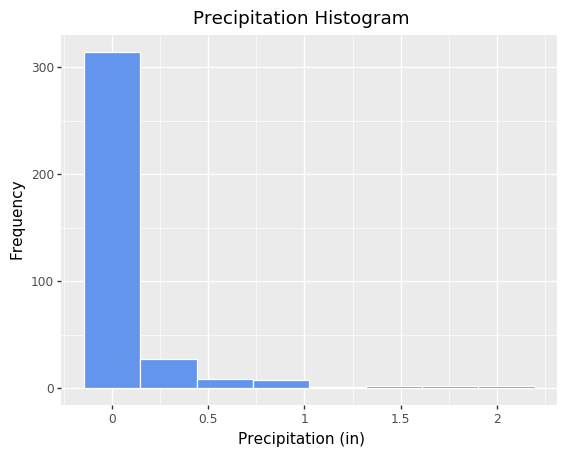

<ggplot: (-9223372036574608573)>

In [41]:
plot = (ggplot(df_weather) +
            geom_histogram(aes(x = 'PRCP'), 
                          bins = 8,
                          color = 'white',
                          fill = 'cornflowerblue') +
        ggtitle('Precipitation Histogram') +
        xlab('Precipitation (in)') +
        ylab('Frequency')
       )
plot

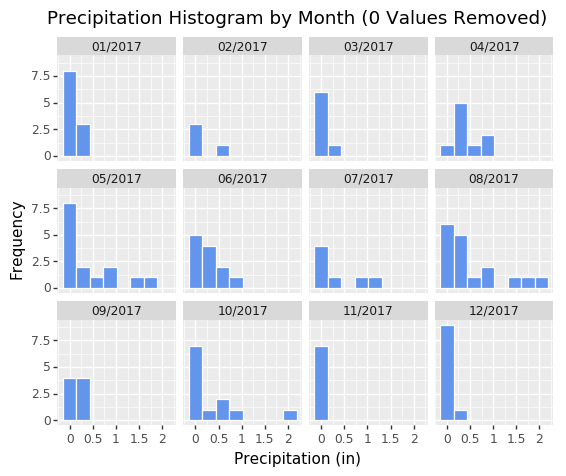

<ggplot: (280167225)>

In [42]:
df_weather_only_prcp = df_weather[df_weather['PRCP'] > 0]

plot = (ggplot(df_weather_only_prcp) +
            geom_histogram(aes(x = 'PRCP'), 
                           bins = 8,
                           color = 'white',
                           fill = 'cornflowerblue') +
            facet_wrap('~MONTH', ncol = 4) +
            ggtitle('Precipitation Histogram by Month (0 Values Removed)') +
            xlab('Precipitation (in)') +
            ylab('Frequency')
       )
plot

It appears that precipitation is very positively skewed. To make the by month plot more interesting, the zero values were removed to highlight actual precipitation amounts. 

#### Max Temperature

The maximim recorded temperature for that day was also measured.

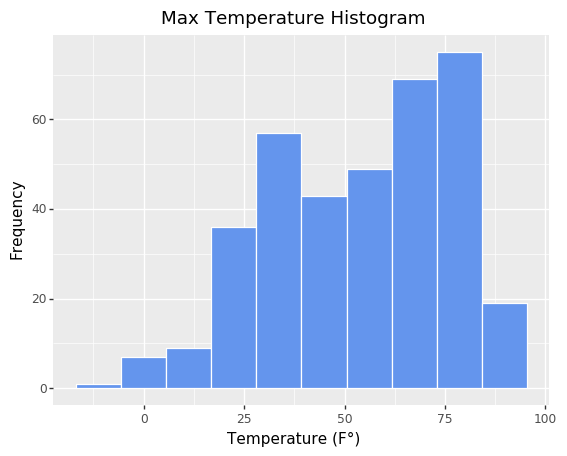

<ggplot: (288990184)>

In [43]:
plot = (ggplot(df_weather) +
            geom_histogram(aes(x = 'TMAX'),
                          color = 'white',
                          fill = 'cornflowerblue') +
        ggtitle('Max Temperature Histogram') +
        xlab('Temperature (F°)') +
        ylab('Frequency')
       )
plot

The max temperatures were then broken out by month and facet wrapped as a histogram.

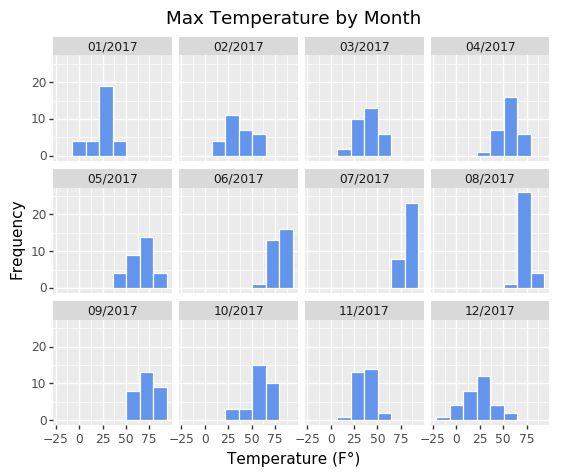

<ggplot: (-9223372036565558233)>

In [44]:
plot = (ggplot(df_weather) +
            geom_histogram(aes(x = 'TMAX'), 
                           bins = 8,
                           color = 'white',
                           fill = 'cornflowerblue') +
            facet_wrap('~MONTH', ncol = 4) +
            ggtitle('Max Temperature by Month') +
            xlab('Temperature (F°)') +
            ylab('Frequency')
       )
plot

The monthly temperatures were averaged.

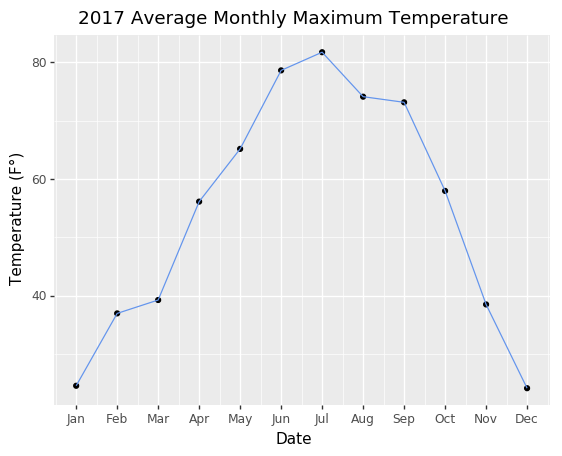

<ggplot: (292344882)>

In [45]:
df_max_average_temp = df_weather.groupby('MONTH')['TMAX'].mean()
df_max_average_temp = df_max_average_temp.reset_index()
df_max_average_temp.columns = ['MONTH', 'TMAX_AVG']

# geom_line connects on values it understands
df_max_average_temp.insert(0, 'MONTH_ID', range(1, 1 + len(df_max_average_temp)))

plot = (ggplot(df_max_average_temp,
              aes(x = 'MONTH_ID', y = 'TMAX_AVG')) +
        geom_point() +
        geom_line(color = 'cornflowerblue') + 
        scale_x_continuous(labels = months[:-1],
                        breaks = df_max_average_temp['MONTH_ID'].tolist(),
                        limits = [1, 12]) +
        ggtitle('2017 Average Monthly Maximum Temperature') +
        xlab('Date') +
        ylab('Temperature (F°)')
)

plot

With the monthly distributions and average temperatures, the seasonal trends are visible. Neat! Next, the same treatments were applied to the minimum temperatures.

#### Minimum Temperature

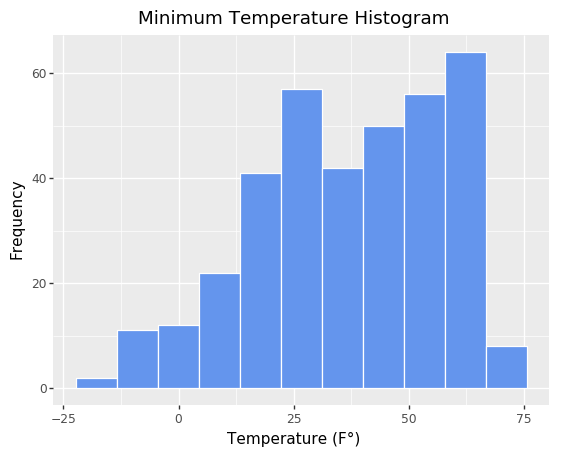

<ggplot: (-9223372036563165247)>

In [46]:
plot = (ggplot(df_weather) +
            geom_histogram(aes(x = 'TMIN'),
                          color = 'white',
                          fill = 'cornflowerblue') +
        ggtitle('Minimum Temperature Histogram') +
        xlab('Temperature (F°)') +
        ylab('Frequency')
       )
plot

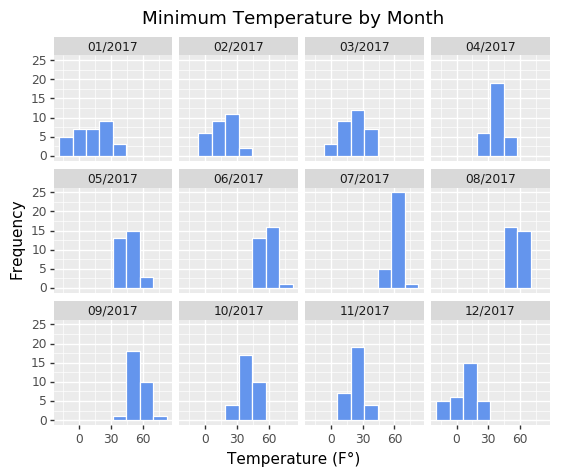

<ggplot: (-9223372036562430951)>

In [47]:
plot = (ggplot(df_weather) +
            geom_histogram(aes(x = 'TMIN'), 
                           bins = 8,
                           color = 'white',
                           fill = 'cornflowerblue') +
            facet_wrap('~MONTH', ncol = 4) +
            ggtitle('Minimum Temperature by Month') +
            xlab('Temperature (F°)') +
            ylab('Frequency')
       )
plot

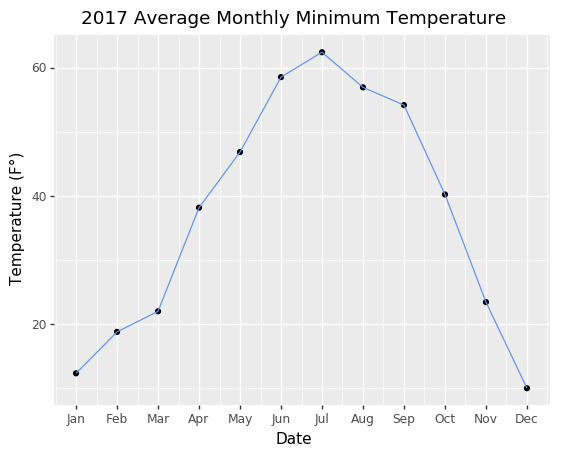

<ggplot: (290421736)>

In [48]:
df_minimum_average_temp = df_weather.groupby('MONTH')['TMIN'].mean()
df_minimum_average_temp = df_minimum_average_temp.reset_index()
df_minimum_average_temp.columns = ['MONTH', 'TMIN_AVG']

# geom_line connects on values it understands
df_minimum_average_temp.insert(0, 'MONTH_ID', range(1, 1 + len(df_minimum_average_temp)))
lambda_month_lookup = lambda x: calendar.month_abbr[x]
df_minimum_average_temp['MONTH_NAME'] = df_minimum_average_temp['MONTH_ID'].apply(lambda_month_lookup)

plot = (ggplot(df_minimum_average_temp,
              aes(x = 'MONTH_ID', y = 'TMIN_AVG')) +
        geom_point() +
        geom_line(color = 'cornflowerblue') + 
        scale_x_continuous(labels = months[:-1],
                        breaks = df_minimum_average_temp['MONTH_ID'].tolist(),
                        limits = [1, 12]) +
        ggtitle('2017 Average Monthly Minimum Temperature') +
        xlab('Date') +
        ylab('Temperature (F°)')
)

plot

Next, I wanted to look at the these variables over time.

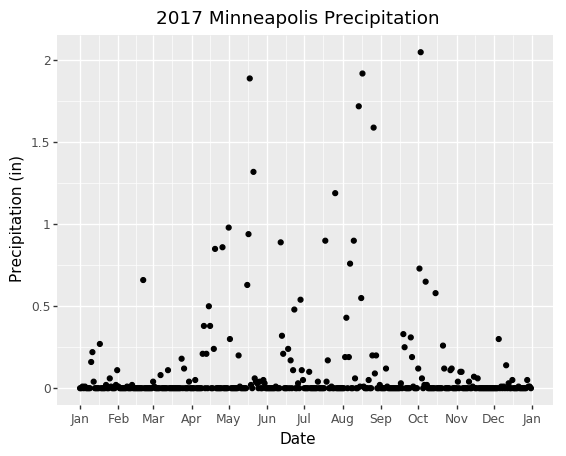

<ggplot: (-9223372036564423550)>

In [49]:
plot = (ggplot(df_weather) + 
    geom_point(aes(x = 'DATE', y = 'PRCP')) + 
    scale_x_date(breaks = date_breaks('1 months'), labels = months) +
    ggtitle('2017 Minneapolis Precipitation') +
    xlab('Date') +
    ylab('Precipitation (in)')
)

plot

That's quite a few days with no recorded precipitation. Let's remove those values and see if there are any apparent trends.

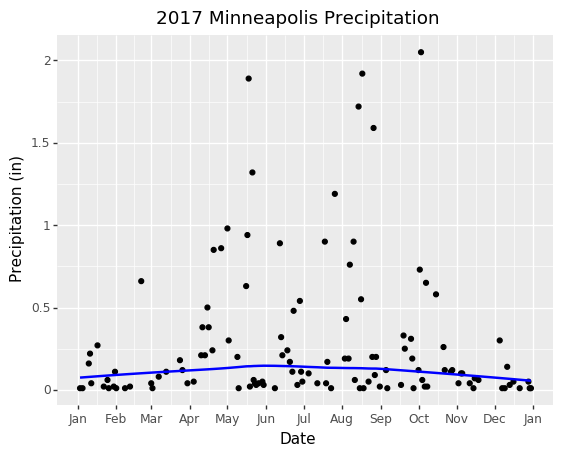

<ggplot: (290085917)>

In [50]:
plot = (ggplot(df_weather_only_prcp) + 
    geom_point(aes(x = 'DATE', y = 'PRCP')) + 
    geom_smooth(aes(x = 'DATE', y = 'PRCP'), color = 'blue') +
    scale_x_date(breaks = date_breaks('1 months'), labels = months) +
    ggtitle('2017 Minneapolis Precipitation') +
    xlab('Date') +
    ylab('Precipitation (in)')
)

plot

Well that was anticlimactic. Looks like with simple inspection, no obvious trends stand out. Let's plot some more of the features over time.

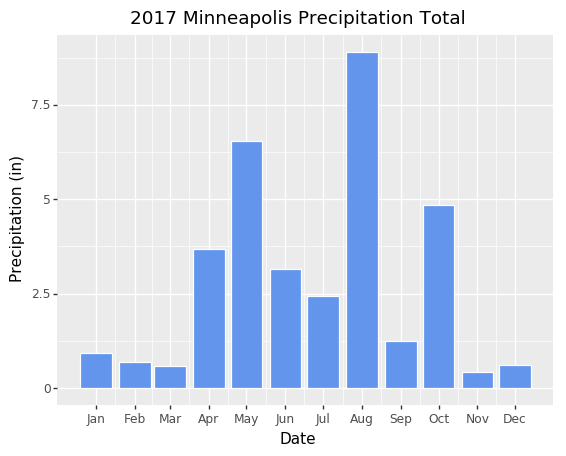

<ggplot: (289021262)>

In [51]:
df_prcp_sum = df_weather.groupby(['MONTH'])['PRCP'].sum()
df_prcp_sum = df_prcp_sum.reset_index()
df_prcp_sum.columns = ['MONTH', 'TOTAL']

plot = (ggplot(df_prcp_sum) +
        geom_bar(aes(x = 'MONTH', y = 'TOTAL'), 
                 stat = 'identity',
                 color = 'white',
                 fill = 'cornflowerblue') +
        scale_x_date(breaks = date_breaks('1 months'), labels = months[:-1]) +
        ggtitle('2017 Minneapolis Precipitation Total') +
        xlab('Date') +
        ylab('Precipitation (in)')
)

plot

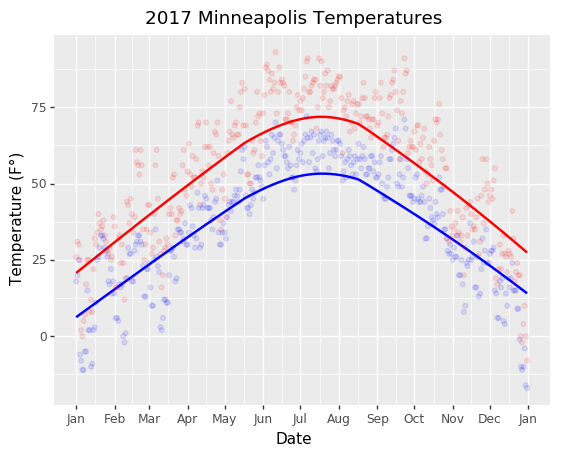

<ggplot: (-9223372036564678782)>

In [52]:
plot = (ggplot(df_weather) +
    geom_smooth(aes(x = 'DATE', y = 'TMAX'), color = 'red') +
    geom_smooth(aes(x = 'DATE', y = 'TMIN'), color = 'blue') +
    geom_point(aes(x = 'DATE', y = 'TMAX'), color = 'red', alpha = 0.1) +
    geom_point(aes(x = 'DATE', y = 'TMIN'), color = 'blue', alpha = 0.1) +
    scale_x_date(breaks = date_breaks('1 months'), labels = months) +
    ggtitle('2017 Minneapolis Temperatures') +
    xlab('Date') +
    ylab('Temperature (F°)')
)

plot

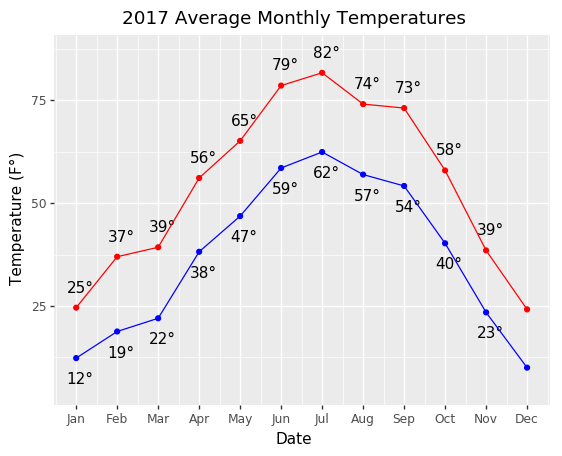

<ggplot: (-9223372036564384729)>

In [53]:
df_average_temps = df_minimum_average_temp.merge(df_max_average_temp)

# Beautify the degrees for labeling 
lambda_apply_degree = lambda x: x + '°'
df_average_temps['TMIN_AVG_L'] = df_average_temps['TMIN_AVG'].round(0).astype(int).astype(str).apply(lambda_apply_degree)
df_average_temps['TMAX_AVG_L'] = df_average_temps['TMAX_AVG'].round(0).astype(int).astype(str).apply(lambda_apply_degree)

plot = (ggplot(df_average_temps) +
        geom_point(aes(x = 'MONTH_ID', y = 'TMIN_AVG'), color = 'blue') +
        geom_text(aes(x = 'MONTH_ID', y = 'TMIN_AVG', label = 'TMIN_AVG_L'), nudge_y = -5, nudge_x = 0.1) +
        geom_point(aes(x = 'MONTH_ID', y = 'TMAX_AVG'), color = 'red') +
        geom_text(aes(x = 'MONTH_ID', y = 'TMAX_AVG', label = 'TMAX_AVG_L'), nudge_y = 5, nudge_x = 0.1) +
        geom_line(aes(x = 'MONTH_ID', y = 'TMIN_AVG'), color = 'blue') +
        geom_line(aes(x = 'MONTH_ID', y = 'TMAX_AVG'), color = 'red') +
        scale_x_continuous(labels = months[:-1],
                        breaks = df_average_temps['MONTH_ID'].tolist(),
                        limits = [1, 12]) +
        ggtitle('2017 Average Monthly Temperatures') +
        xlab('Date') +
        ylab('Temperature (F°)')
)

plot

It looks like the average temperature in October is between 40° and 58°, but there was a significant amount of rain compared to the surrounding months. I remember getting blizzards in October, not rain!

#### Correlation

Okay, next, a correlation matrix.


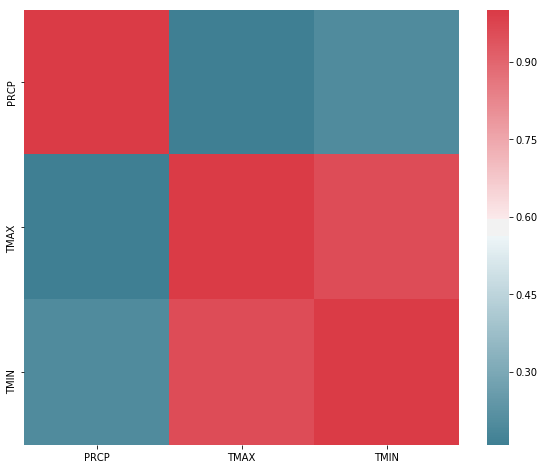

In [54]:
# Correlation code from:
# https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas#29432741

f, ax = plt.subplots(figsize=(10, 8))
corr = df_weather.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


Well that's also anticlimactic. It makes sense that the maximum and minimum temperatures correlate with each other. Precipitation appears to negatively correlated with temperature.

### Trip Summaries Data Inspection

This a significantly larger dataset than the weather and station data. It contains the start and end times, with the time elapsed conveniently calculated for me. Other attributes include the station name and number, the latter can be linked to the station database, and whether or not the customer that used the bike was a member of the Nice Ride service or not. 

As with the weather data, some additional transformations were applied to make it easier to group the trips together.

In [55]:
def correct_date_string(row):
    '''
    Takes american formatted dates ('MM/DD/YYYY') and converts them to a standard YYYY-MM-DD format
    Intended to be "apply()-ed" to each row of a dataframe column.
    
    Parameters:
    row (str): A cell of a dataframe column in the 'MM/DD/YYYY' format
    
    Returns:
    str: The same date passed in but in YYYY-MM-DD format
    '''
    date_components = str(row).split('/')
    
    corrected_date_components = []
    for item in date_components:
        if len(item) == 1:
            new_component = '0' + str(item)
            corrected_date_components.append(new_component)
        else:
            corrected_date_components.append(item)
            
    corrected_date_ordering = [corrected_date_components[2], corrected_date_components[0], corrected_date_components[1]]
    return('-'.join(corrected_date_ordering))

lambda_split_date = lambda row: str(row).split(' ')[0]
lambda_split_time = lambda row: str(row).split(' ')[1]

# Split out the dates into their own column
df_trips['StartDate'] = df_trips['Start date'].apply(lambda_split_date)
df_trips['EndDate'] = df_trips['End date'].apply(lambda_split_date)

# Split out the times into their own column
df_trips['StartTime'] = df_trips['Start date'].apply(lambda_split_time)
df_trips['EndTime'] = df_trips['End date'].apply(lambda_split_time)

# Correct the date formatting
df_trips['StartDate'] = df_trips['StartDate'].apply(correct_date_string)
df_trips['EndDate'] = df_trips['EndDate'].apply(correct_date_string)

# Set the datatypes
lambda_convert_minutes = lambda x: int(x/60)

df_trips['StartDate'] = df_trips['StartDate'].astype('datetime64[ns]')
df_trips['EndDate'] = df_trips['EndDate'].astype('datetime64[ns]')
df_trips['Duration'] = df_trips['Total duration (Seconds)'].astype(int).apply(lambda_convert_minutes)
df_trips['Start station number'] = df_trips['Start station number'].astype(str)
df_trips['End station number'] = df_trips['End station number'].astype(str)

# Add month 
df_trips['StartMonthYear'] = df_trips['StartDate'].apply(lambda_get_date)

# Drop unnecessary columnsn and rename poorly named columns
df_trips_corrected = df_trips.drop(['Start date', 'End date', 'Total duration (Seconds)', 'Start station', 'End station'], axis = 1)
df_trips_corrected = df_trips_corrected.rename(columns = {'Account type': 'AccountType', 
                                      'Start station number': 'StartStation',
                                      'End station number': 'EndStation'})

print_df_summary(df_trips_corrected, 'df_trips')

df_trips has 460718 rows and 9 columns.

  StartStation EndStation AccountType  StartDate    EndDate StartTime EndTime  \
0        30184      30104      Member 2017-11-05 2017-11-05     21:45   22:02   
1        30122      30122      Member 2017-11-05 2017-11-05     21:45   22:26   
2        30106      30101      Member 2017-11-05 2017-11-05     21:43   22:13   
3        30183      30014      Casual 2017-11-05 2017-11-05     21:41   22:05   
4        30030      30088      Member 2017-11-05 2017-11-05     21:38   21:44   

   Duration StartMonthYear  
0        17        11/2017  
1        41        11/2017  
2        30        11/2017  
3        23        11/2017  
4         6        11/2017  

df_trips has the following nulls:
StartStation      0
EndStation        0
AccountType       0
StartDate         0
EndDate           0
StartTime         0
EndTime           0
Duration          0
StartMonthYear    0
dtype: int64

            Duration
count  460718.000000
mean       37.450829
std   

#### Total Trips

First, the daily totals, then monthly totals.

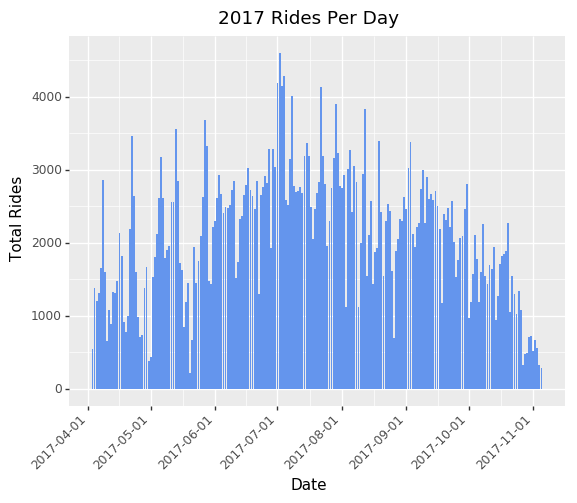

<ggplot: (277531975)>

In [56]:
df_trips_total_day = df_trips_corrected.groupby(['StartDate']).size()
df_trips_total_day = df_trips_total_day.reset_index()
df_trips_total_day.columns = ['StartDate', 'Total']
df_trips_total_day['StartDate'] = df_trips_total_day['StartDate'].astype('datetime64[ns]')

plot = (ggplot(df_trips_total_day) +
        geom_bar(aes(x = 'StartDate', y = 'Total'), 
                 stat = 'identity',
                 fill = 'cornflowerblue') +
        ggtitle('2017 Rides Per Day') +
        xlab('Date') +
        ylab('Total Rides') +
        theme(axis_text_x = element_text(rotation = 45, hjust = 1))
)

plot

The gaps are pretty interesting, and the distribution looks fairly normal. Unexpectedly, there is no apparent Nice Ride service from December to March. I know people that bike all winter, but I can empathize with the business decision -- Minnesota winters can be very brutal. 

Let's take a closer look at the gaps. My intuition tells me, perhaps the gaps are on the weekends and that the Nice Ride service is primarily used by commuters during the weekdays.

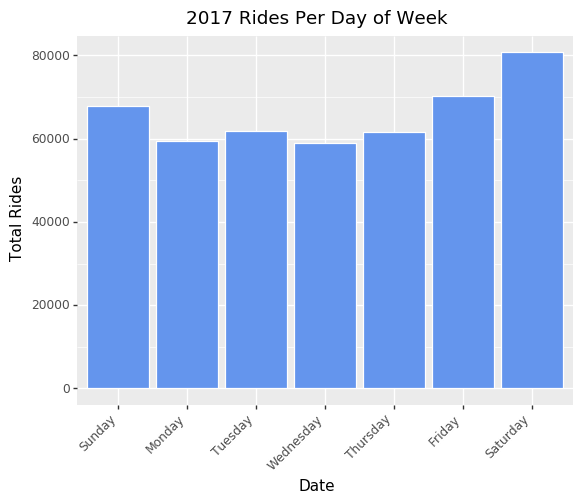

<ggplot: (-9223372036564532073)>

In [57]:
map_weekday = {0: 'Monday',
               1: 'Tuesday',
               2: 'Wednesday',
               3: 'Thursday',
               4: 'Friday',
               5: 'Saturday',
               6: 'Sunday'}
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Map date to weekday
df_trips_total_day['Weekday'] = df_trips_total_day['StartDate'].apply(lambda x: x.weekday()).replace(map_weekday)
df_trips_total_weekday = df_trips_total_day.groupby('Weekday')['Total'].sum()

# Order days of the week as expected
df_trips_total_weekday = df_trips_total_weekday.reset_index()
df_trips_total_weekday['Weekday'] = pd.Categorical(df_trips_total_weekday['Weekday'], categories = day_order, ordered = True)

plot = (ggplot(df_trips_total_weekday) +
        geom_bar(aes(x = 'Weekday', y = 'Total'), 
                 stat = 'identity',
                 color = 'white',
                 fill = 'cornflowerblue') +
        ggtitle('2017 Rides Per Day of Week') +
        xlab('Date') +
        ylab('Total Rides') +
        theme(axis_text_x = element_text(rotation = 45, hjust = 1))
)

plot

Okay, well that hypothesis was completely wrong. Weekends trend higher than weekdays. Instead, we'll slice out a smaller portion of the total data set to look at the gaps closer.

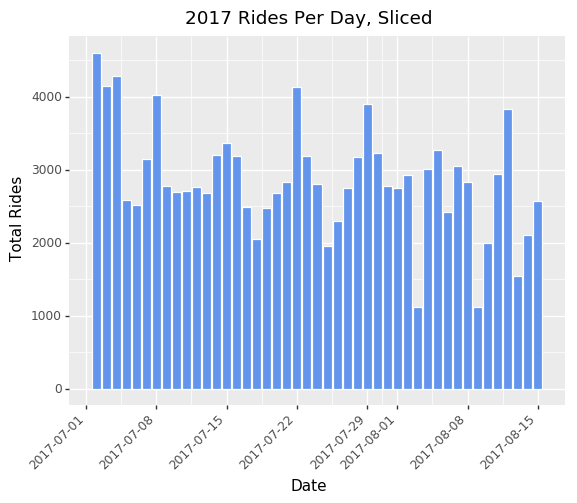

<ggplot: (292886413)>

In [58]:
df_trips_total_slice = df_trips_total_day[df_trips_total_day['StartDate'].between('2017-07-02', '2017-08-15')]

plot = (ggplot(df_trips_total_slice) +
        geom_bar(aes(x = 'StartDate', y = 'Total'), 
                 stat = 'identity',
                 color = 'white',
                 fill = 'cornflowerblue') +
        ggtitle('2017 Rides Per Day, Sliced') +
        xlab('Date') +
        ylab('Total Rides') +
        theme(axis_text_x = element_text(rotation = 45, hjust = 1))
)

plot

Hmm, perhaps the gaps are just a visual issue with `ggplot`, but it was a fun exercise and some new things were learned.

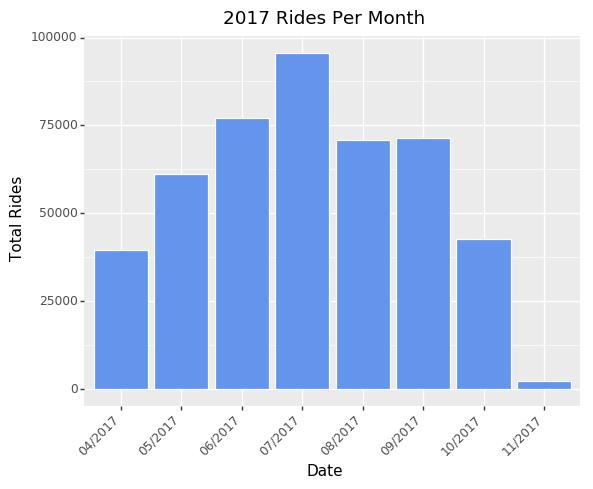

<ggplot: (290688758)>

In [59]:
df_trips_total_day = df_trips_corrected.groupby(['StartMonthYear']).size()
df_trips_total_day = df_trips_total_day.reset_index()
df_trips_total_day.columns = ['StartDate', 'Total']

plot = (ggplot(df_trips_total_day) +
        geom_bar(aes(x = 'StartDate', y = 'Total'), 
                 stat = 'identity',
                 color = 'white',
                 fill = 'cornflowerblue') +
        ggtitle('2017 Rides Per Month') +
        xlab('Date') +
        ylab('Total Rides') +
        theme(axis_text_x = element_text(rotation = 45, hjust = 1))
)

plot

Well the summer months certainly get their use, but fall and spring are adequately represented as well, with a few rides in November, brave souls. Now, let's look at the times.

#### Time

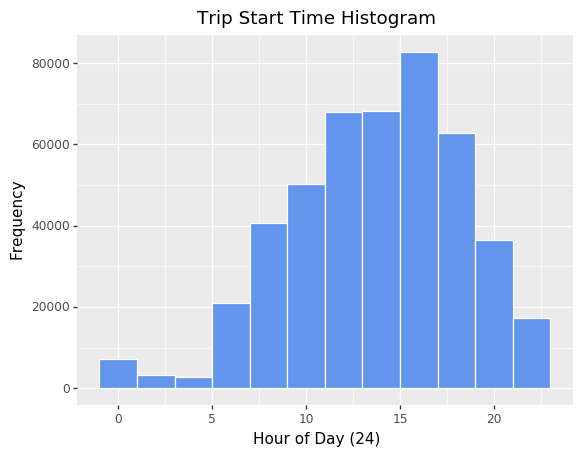

<ggplot: (-9223372036564351102)>

In [60]:
# Find the trip start hour, suitable for binning
lambda_split_time_hour = lambda x: int(str(x).split(':')[0])
df_trips_corrected['Hour'] = df_trips_corrected['StartTime'].apply(lambda_split_time_hour)

plot = (ggplot(df_trips_corrected) +
            geom_histogram(aes(x = 'Hour'),
                          color = 'white',
                          fill = 'cornflowerblue',
                          binwidth = 2) +
        ggtitle('Trip Start Time Histogram') +
        xlab('Hour of Day (24)') +
        ylab('Frequency')
       )
plot

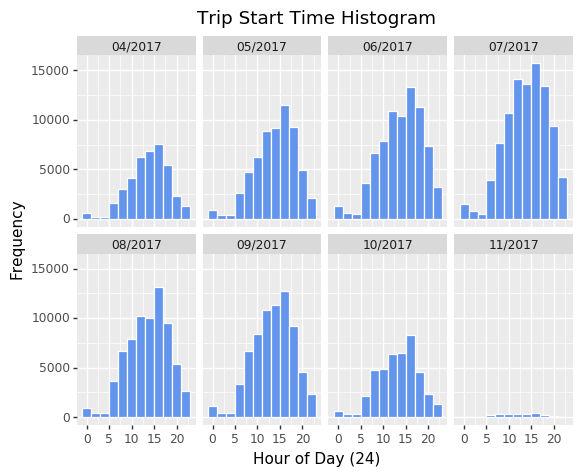

<ggplot: (-9223372036564660834)>

In [61]:
plot = (ggplot(df_trips_corrected) +
            geom_histogram(aes(x = 'Hour'),
                          color = 'white',
                          fill = 'cornflowerblue',
                          binwidth = 2) +
        facet_wrap('~StartMonthYear', ncol = 4) +
        ggtitle('Trip Start Time Histogram') +
        xlab('Hour of Day (24)') +
        ylab('Frequency')
       )
plot

It looks like most trips occur around possible lunch breaks. Honestly, I expected more early morning and late afternoon rides. Perhaps people aren't taking Nice Ride bikes as their main commute option but instead, to grab lunch or run a brief errand. Most of the stations in Minneapolis are in the central business district and the University of Minnesota so perhaps that makes sense. 

### Duration

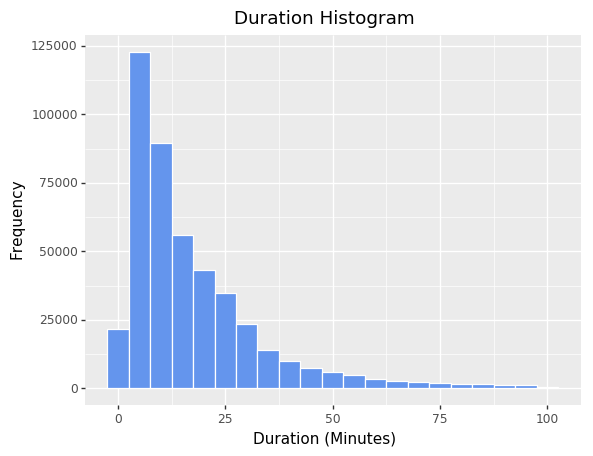

<ggplot: (-9223372036564679066)>

In [62]:
df_duration_under_25 = df_trips_corrected[df_trips_corrected['Duration'] < 100]

plot = (ggplot(df_duration_under_25) +
            geom_histogram(aes(x = 'Duration'),
                          color = 'white',
                          fill = 'cornflowerblue',
                          binwidth = 5) +
        ggtitle('Duration Histogram') +
        xlab('Duration (Minutes)') +
        ylab('Frequency')
       )
plot

I actually found that most rides fell into these buckets. There were a few incredible outliers, including one trip duration that lasted over 130 days. My rough estimate based on the pricing of Nice Ride was about $12,000. Ouch!

I tried to bin the outliers below.

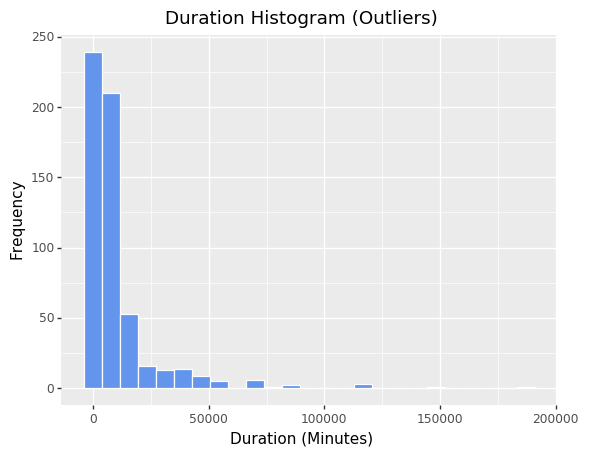

<ggplot: (290082575)>

In [63]:
df_duration_outliers = df_trips_corrected[(np.abs(df_trips_corrected['Duration'] - df_trips_corrected['Duration'].mean()) > (3 * df_trips_corrected['Duration'].std()))]

plot = (ggplot(df_duration_outliers) +
            geom_histogram(aes(x = 'Duration'),
                          color = 'white',
                          fill = 'cornflowerblue',
                          bins = 25) +
        ggtitle('Duration Histogram (Outliers)') +
        xlab('Duration (Minutes)') +
        ylab('Frequency')
       )
plot

### Start Station

In [64]:
df_start_station_counts = pd.DataFrame(df_trips_corrected.groupby('StartStation').size()).reset_index()
df_start_station_counts.columns = ['Number', 'RideCount']

# Evenly scale the number of rides to even out the radius for the plot
scaler = MinMaxScaler(feature_range = (0.5, 10))
scaler.fit(df_start_station_counts[['RideCount']])
df_start_station_counts['Scale'] = scaler.transform(df_start_station_counts[['RideCount']])

df_start_station_scaled = pd.merge(df_stations_mpls, df_start_station_counts, on = 'Number')
build_map(df_start_station_scaled, should_scale = True)

The larger the circle, the more popular the station. The popular starting locations appear to be around Bde Maka Ska (the lake in southwest corner), the central business district of Downtown, and the University of Minnesota campus. These align with my expectations as rides can be for pleasure (around the lake), for work (Downtown), and for school (U campus).

Let's apply the same treatment to the end stations.

### End Station

In [65]:
df_end_station_counts = pd.DataFrame(df_trips_corrected.groupby('EndStation').size()).reset_index()
df_end_station_counts.columns = ['Number', 'RideCount']

# Evenly scale the number of rides to even out the radius for the plot
scaler = MinMaxScaler(feature_range = (0.5, 10))
scaler.fit(df_end_station_counts[['RideCount']])
df_end_station_counts['Scale'] = scaler.transform(df_end_station_counts[['RideCount']])

df_end_station_scaled = pd.merge(df_stations_mpls, df_end_station_counts, on = 'Number')
build_map(df_end_station_scaled, should_scale = True)

Hmm, looks pretty similar to the Start Station results.

### Most Popular Route

In [66]:
# Count stations
df_popular_trips = pd.DataFrame(df_trips_corrected.groupby(['StartStation', 'EndStation']).size()).reset_index(drop = False)
df_popular_trips.columns = ['StartStationNumber', 'EndStationNumber', 'RouteCount']

# Swap out station numbers with names
map_station_names = df_stations.set_index('Number').to_dict()['Name']
df_popular_trips['StartStation'] = df_popular_trips['StartStationNumber'].replace(map_station_names)
df_popular_trips['EndStation'] = df_popular_trips['EndStationNumber'].replace(map_station_names)

# Get top ten
df_popular_trips_10 = df_popular_trips.nlargest(10, 'RouteCount').reset_index(drop = True)

# Set datatypes
df_popular_trips_10 = df_popular_trips_10.reset_index(drop = True)
df_popular_trips_10['RouteCount'] = df_popular_trips_10['RouteCount'].astype(int)

# Clean up dataframe
df_popular_trips_10 = df_popular_trips_10.drop(['StartStationNumber', 'EndStationNumber'], axis = 1)
df_popular_trips_10 = df_popular_trips_10.sort_values(by = ['RouteCount'], ascending = False)
df_popular_trips_10.head(10)

,RouteCount,StartStation,EndStation
0,4853,Lake Street & Knox Ave S,Lake Street & Knox Ave S
1,3171,Lake Calhoun Center,Lake Calhoun Center
2,2650,Lake Harriet Bandshell,Lake Harriet Bandshell
3,2156,Lake Como Pavilion,Lake Como Pavilion
4,2037,W 36th Street & W Calhoun Parkway,W 36th Street & W Calhoun Parkway
5,1857,Willey Hall,Weisman Art Museum
6,1832,Weisman Art Museum,Willey Hall
7,1647,Minnehaha Park,Minnehaha Park
8,1574,Weisman Art Museum,Social Sciences
9,1361,Lake Nokomis,Lake Nokomis


Very interesting! The most popular routes ended up being a loop of some sort. There could be many explainations for this, here's a few that I considered: 

* Popular routes are around activities such as lakes, so individual commutes around town get lost.
* There is some sort of anxiety around finding another docking station, so people run their errand and return it where they got it from.
* People use public transportation or personal car to reach a 'hub point,' then use Nice Ride bikes to perform some sort of local errand. 

Let's try to find popular stops that had a different starting station from the ending station.

In [67]:
df_different_popular_trips = df_popular_trips[df_popular_trips['StartStation'] != df_popular_trips['EndStation']]
df_different_popular_trips = df_different_popular_trips.sort_values(by = 'RouteCount', ascending = False)
df_different_popular_trips = df_different_popular_trips.drop(['StartStationNumber', 'EndStationNumber'], axis = 1)
df_different_popular_trips.head(10)

,RouteCount,StartStation,EndStation
18742,1857,Willey Hall,Weisman Art Museum
17377,1832,Weisman Art Museum,Willey Hall
17265,1574,Weisman Art Museum,Social Sciences
2533,1245,Social Sciences,Weisman Art Museum
12155,934,Washington Ave SE & Union Street SE,4th Street & 13th Ave SE
1209,919,4th Street & 13th Ave SE,Washington Ave SE & Union Street SE
15009,838,Lake Street & Knox Ave S,Lake Harriet Bandshell
15654,828,W 36th Street & W Calhoun Parkway,Lake Street & Knox Ave S
12283,822,Washington Ave SE & Union Street SE,15th Ave SE & 4th Street SE
9862,805,Lake Calhoun Center,Lake Street & Knox Ave S


With the basic EDA complete, let's jump into the modeling and answering the questions.

## Modeling

### Question 1:  Do stations align with neighboorhoods?

Minneapolis isn't as neighboorhood focused as San Francisco, but it does have it's regions. I thought it would interesting to check for clusters of stations and see if they align with the fuzzy boundaries of Minneapolis neighboorhoods. I started with KMeans clustering.

In [68]:
df_stations_locations = df_stations_mpls[['Latitude', 'Longitude']]
model_cluster = KMeans(n_clusters = 5, init = 'random')
model_cluster.fit_transform(df_stations_locations)

df_stations_mpls['Cluster'] = model_cluster.labels_
build_map(df_stations_mpls, should_cluster = True)

Actually, this works pretty well. Uptown (blue), Downtown (Purple), South (Yellow) and the University of Minnesota campus (Red) are fairly aligned. North Minneapolis (green) is mostly correct, but some of the green, purple, and red points to the east of the Mississippi river should be the neighborhood of Northeast. I wonder if adding more clusters would get better results.

In [69]:
df_stations_locations = df_stations_mpls[['Latitude', 'Longitude']]
model_cluster = KMeans(n_clusters = 8, init = 'random')
model_cluster.fit_transform(df_stations_locations)

df_stations_mpls['Cluster'] = model_cluster.labels_
build_map(df_stations_mpls, should_cluster = True)

With eight clusters, the neighborhoods are almost perfect. Some of the blue points south of the river should be orange, and the white points that are east of the pink points should be pink, for downtown. Pretty close though!

Let's try a different clustering algorithm. I feel like `dbscan` is the way to go here since I want neighborhoods that exist organically to appear. There are some stations, like the one farthest to the north that I personally would classify as "unclustered" which is something `dbscan` supports.

In [70]:
# Calculate distance, math from:
# https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
km_per_radian = 6371.0088
epsilon = 1.2 / km_per_radian

df_stations_locations = df_stations_mpls[['Latitude', 'Longitude']]
model_dbscan = DBSCAN(eps = epsilon, min_samples = 2, metric = 'haversine', algorithm = 'ball_tree')
labels = model_dbscan.fit_predict(np.radians(np.array(df_stations_locations)))

labels = np.absolute(labels)
df_stations_mpls['Cluster'] = labels
build_map(df_stations_mpls, should_cluster = True)

This result ended up being the best I could do with many iterations and attempts to find appropriate epsilon and minimum samples. The result isn't very great. How about one more try with one more clustering method: Spectral Clustering.

In [71]:
df_stations_locations = df_stations_mpls[['Latitude', 'Longitude']]

model_specrtral = SpectralClustering(n_clusters = 7, 
                                     assign_labels = 'discretize', 
                                     n_init = 50,
                                     affinity = 'nearest_neighbors',
                                     random_state = 74656)
labels = model_specrtral.fit_predict(df_stations_locations)

df_stations_mpls['Cluster'] = labels
build_map(df_stations_mpls, should_cluster = True)

Ultimately I think that this is the best outcome I could have hoped for. The inner downtown in pink is separated from the outer downtown in blue. A few of the Northeast stations (purple) have been misclassified as yellow for North Minneapolis. But the University of Minnesota stations (green), South Minneapolis (orange) and Uptown (red)stations are nearly perfect. 

To answer the original question, yes, I do think stations map to established neighborhoods.

### Question 2: Can predictions about the number of rides per day based weather be accomplished with 80% or more accuracy?

I'll start by plotting a correlation to see how the total number of rides with the other variables. 

In [72]:
df_trips_total_day = pd.DataFrame(df_trips_corrected.groupby('StartDate').size().reset_index())
df_trips_total_day.columns = ['DATE', 'TotalTrips']
df_trips_by_weather = pd.merge(df_trips_total_day, df_weather, on = 'DATE').drop(['STATION', 'MONTH', 'NAME'], axis = 1)

# Split data into features and labels
df_X = df_trips_by_weather[['PRCP', 'TMAX', 'TMIN']]
df_y = df_trips_by_weather[['TotalTrips']]

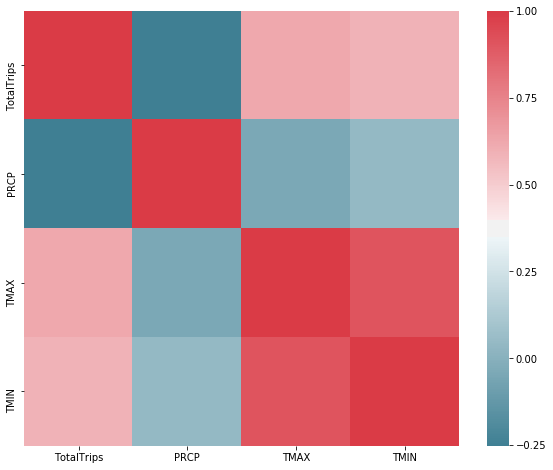

In [73]:
# correlation code from:
# https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas#29432741

f, ax = plt.subplots(figsize=(10, 8))
corr = df_trips_by_weather.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


There are naturally strong correlations between the minimum and maximum temperature. There is also a medium correlation between temperature and precipitation. As for their effect on rides, it appears that there is a medium positive correlation with temperature and rides. Makes sense, warm days make a bike ride seem very appealing. There's also a fairly strong negative correlation with precipitation and number of rides. It turns out, it's not fun to bike in the rain. 

To me, this looks like it would be decent at making predictions.

In [74]:
def regressor(df_X, df_y):
    '''
    Builds a regression model, trains it, tests it, and returns all calculations.
    
    Parameters:
    df_X (dataframe): The x values used in the regression
    df_y (dataframe): The target y labels
    
    Returns:
    dataframe: (predictions) predictions found with the test set
    dataframe: (X_test) the values split out from the training set used to calculate the predictions
    dataframe: (y_test) the labels split out from the training set used to calculate the predictions
    '''
    # Code adapted from
    # https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25,
                                                    random_state = 74656)


    regressor = RandomForestRegressor(n_estimators = 5000, random_state = 74656)
    regressor.fit(X_train, y_train);
    predictions = regressor.predict(X_test)

    errors = abs(predictions - y_test['TotalTrips'])
    mape = 100 * (errors / y_test['TotalTrips'])
    accuracy = 100 - np.mean(mape)

    print('Accuracy: ' + str(round(accuracy, 2)) + '%.')
    return(predictions, X_test, y_test)

I had never used a regression before, so I found a nice [tutorial](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0) that helped me work with my dataset. I wrote a method to calculate the accuracy of a `RandomForestRegressor`. The first dataset I used was the original set, which includes precipitation, minimum temperature, and maximum temperature with the number of rides that day as the target.

In [75]:
predictions, X_test, y_test = regressor(df_X, df_y)

Accuracy: 60.45%.


In [76]:
X_test['Actual'] = y_test['TotalTrips']
X_test['Predicted'] = predictions
X_test = X_test.reset_index(drop = True).reset_index()

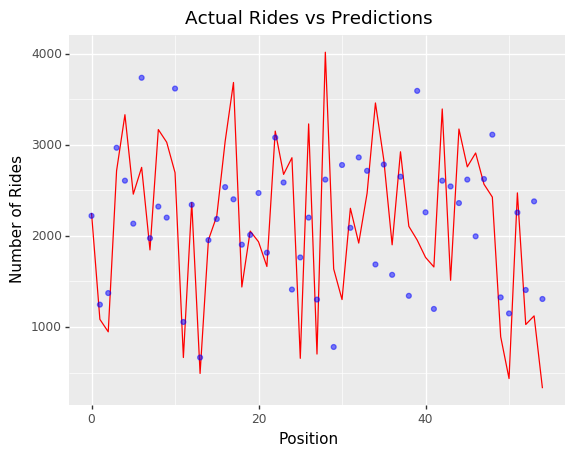

<ggplot: (289928740)>

In [77]:
plot = (ggplot(X_test) +
        geom_line(aes(x = 'index',
                      y = 'Actual'),
                  color = 'red',
                  alpha = 1.0
                 ) +
        geom_point(aes(x = 'index',
                       y = 'Predicted'),
                   color = 'blue',
                  alpha = 0.5
                  ) +
        ggtitle('Actual Rides vs Predictions') +
        xlab('Position') +
        ylab('Number of Rides')
)

plot

Ouch, that's not very accurate. I wonder if adding a new feature for day of the week would improve results.

In [78]:
# Sum up trips
df_trips_total_day = pd.DataFrame(df_trips_corrected.groupby('StartDate').size().reset_index())
df_trips_total_day.columns = ['DATE', 'TotalTrips']

# Add day of week feature
df_trips_total_day['DAYOFWEEK'] = df_trips_total_day['DATE'].apply(lambda x: x.weekday()).replace(map_weekday)

# Merge datasets
df_trips_by_weather = pd.merge(df_trips_total_day, df_weather, on = 'DATE').drop(['STATION', 'MONTH', 'NAME'], axis = 1)

# Convert day of week feature to dummy
df_day_of_week_dummies = pd.get_dummies(df_trips_by_weather['DAYOFWEEK']).reset_index(drop = True).reset_index()
df_X = df_trips_by_weather[['PRCP', 'TMAX', 'TMIN']].reset_index(drop = True).reset_index()

# Split out into features and labels
df_X = pd.merge(df_X, df_day_of_week_dummies, on = 'index')
df_X = df_X.drop('index', axis = 1)
df_y = df_trips_by_weather[['TotalTrips']]

In [79]:
predictions, X_test, y_test = regressor(df_X, df_y)

Accuracy: 63.38%.


In [80]:
X_test['Actual'] = y_test['TotalTrips']
X_test['Predicted'] = predictions
X_test = X_test.reset_index(drop = True).reset_index()

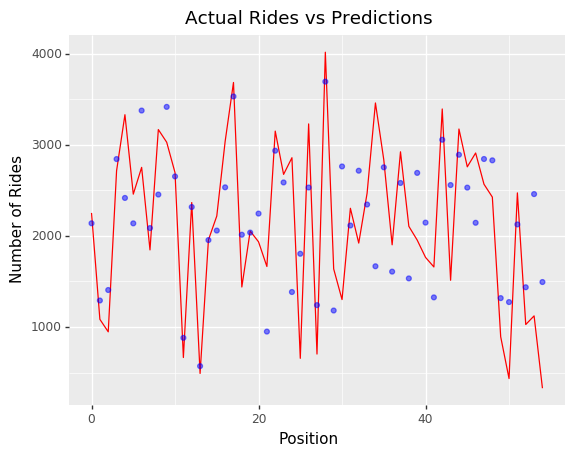

<ggplot: (289924528)>

In [81]:
plot = (ggplot(X_test) +
        geom_line(aes(x = 'index',
                      y = 'Actual'),
                  color = 'red',
                  alpha = 1.0
                 ) +
        geom_point(aes(x = 'index',
                       y = 'Predicted'),
                   color = 'blue',
                  alpha = 0.5
                  ) +
        ggtitle('Actual Rides vs Predictions') +
        xlab('Position') +
        ylab('Number of Rides')
)

plot

Hmm, that's not too much better. Let's try adding a feature to represent the season. I tried to map the seasons to how they actually *feel* in Minnesota and not how they align with the actual season. For example, typically Novembers in Minnesota can have below freezing temperatures and snow. 

In [82]:
# Link month of the 'feeling' of the season
map_season = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter'
}

# Sum up trips
df_trips_total_day = pd.DataFrame(df_trips_corrected.groupby('StartDate').size().reset_index())
df_trips_total_day.columns = ['DATE', 'TotalTrips']

# Pull out the month from the date column
lambda_get_month = lambda x: int(str(x).split('-')[1])
df_trips_total_day['MONTH'] = df_trips_total_day['DATE'].apply(lambda_get_month)

# Convert the month extracted above to a season
df_trips_total_day['SEASON'] = df_trips_total_day['MONTH'].map(map_season)
df_trips_total_day = df_trips_total_day.drop('MONTH', axis = 1)
df_trips_by_weather = pd.merge(df_trips_total_day, df_weather, on = 'DATE').drop(['STATION', 'MONTH', 'NAME'], axis = 1)

# Convert season feature to dummies
df_season_dummies = pd.get_dummies(df_trips_by_weather['SEASON']).reset_index(drop = True).reset_index()
df_X = df_trips_by_weather[['PRCP', 'TMAX', 'TMIN']].reset_index(drop = True).reset_index()

# Split out into features and labels
df_X = pd.merge(df_X, df_season_dummies, on = 'index')
df_X = df_X.drop('index', axis = 1)
df_y = df_trips_by_weather[['TotalTrips']]

In [83]:
predictions, X_test, y_test = regressor(df_X, df_y)

Accuracy: 60.82%.


In [84]:
X_test['Actual'] = y_test['TotalTrips']
X_test['Predicted'] = predictions
X_test = X_test.reset_index(drop = True).reset_index()

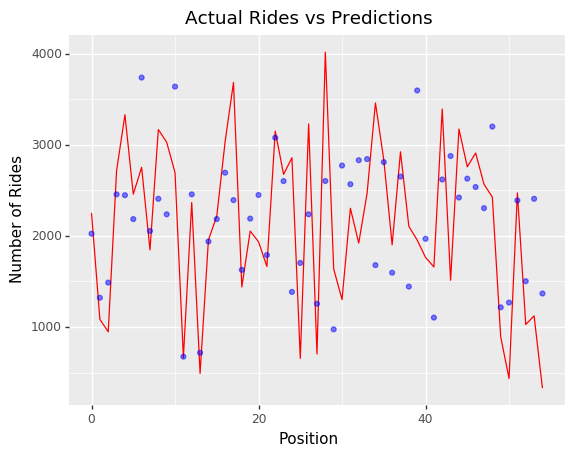

<ggplot: (290760957)>

In [85]:
plot = (ggplot(X_test) +
        geom_line(aes(x = 'index',
                      y = 'Actual'),
                  color = 'red',
                  alpha = 1.0
                 ) +
        geom_point(aes(x = 'index',
                       y = 'Predicted'),
                   color = 'blue',
                  alpha = 0.5
                  ) +
        ggtitle('Actual Rides vs Predictions') +
        xlab('Position') +
        ylab('Number of Rides')
)

plot

To answer this question, it looks like we can predict the total number of trips based soley on precipitation, maximum temp, and minimum temp to about 63% accuracy by adding a day of the weak feature. That's not particularly great. Perhaps more data is required to get better results.

### Question 3:  Can the speed of trips between stations be calculated?

For the final question, I wanted to calculate the speed that riders take. Of course to do this, I must use trip records where people ended at a different location than where they started. Without knowing the exact route auser took, I can approximate by performing an 'as the crow flies' estimate between the starting and ending locations.

In [86]:
# Find trips with different start and ending locations and select only the columns we want
df_trips_different_start_end = pd.DataFrame(df_trips_corrected[df_trips_corrected['StartStation'] != df_trips_corrected['EndStation']])
df_trips_different_start_end = df_trips_different_start_end.drop(['AccountType', 'StartDate', 'EndDate', 'StartTime', 'EndTime', 'StartMonthYear', 'Hour'], axis = 1)

# Break out different tables to match up with coordates
df_trips_start = df_trips_different_start_end.drop(['EndStation', 'Duration'], axis = 1)
df_trips_start.columns = ['Number']

df_trips_end = df_trips_different_start_end.drop(['StartStation', 'Duration'], axis = 1)
df_trips_end.columns = ['Number']

# Drop station columns we don't need
df_stations_simplified = df_stations_mpls.drop(['Name', 'Total docks', 'Cluster'], axis = 1)

# Combine separated tables with station locations
df_trips_start = pd.merge(df_trips_start, df_stations_simplified, on = 'Number')
df_trips_start.columns = ['StartStation', 'StartLat', 'StartLon']

df_trips_end = pd.merge(df_trips_end, df_stations_simplified, on = 'Number')
df_trips_end.columns = ['EndStation', 'EndLat', 'EndLon']

# Combine separted dataframes into one 
df_trips_start_end = pd.merge(df_trips_start, df_trips_end, left_index = True, right_index = True)
df_trips_start_end = df_trips_start_end.drop(['StartStation', 'EndStation'], axis = 1)
df_trips_different_start_end = pd.merge(df_trips_different_start_end, df_trips_start_end, left_index = True, right_index = True)

df_trips_different_start_end.head()

,StartStation,EndStation,Duration,StartLat,StartLon,EndLat,EndLon
0,30184,30104,17,44.981895,-93.269195,44.99882,-93.25276
2,30106,30101,30,44.981895,-93.269195,44.99882,-93.25276
3,30183,30014,23,44.981895,-93.269195,44.99882,-93.25276
4,30030,30088,6,44.981895,-93.269195,44.99882,-93.25276
5,30197,30034,5,44.981895,-93.269195,44.99882,-93.25276


With the start and stop coordinates put together, along with the duration of the trip, I can use a formula to calculate the distance in kilometers with a formula I found.

In [87]:
def dist_between_points(row):
    '''
    Calculates the distance in kilometers between two latitude and longitude coordinates. 
    Intended to be applied to an entire row.
    
    Parameters:
    row (dataframe): A dataframe row with the following columns: StartLat, StartLon, EndLat, EndLon
    
    Returns:
    float: Distance in kilometers between the two points
    '''
    
    # Formula adapted from:
    # https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude#19412565
    
    coords1 = (row['StartLat'], row['StartLon'])
    coords2 = (row['EndLat'], row['EndLon'])

    distance = geopy.distance.vincenty(coords1, coords2).km
    
    return(distance)

This can take a bit!

In [88]:
df_trips_different_start_end['DistanceKM'] = df_trips_different_start_end.apply(dist_between_points, axis = 1)
df_trips_different_start_end.head()

,StartStation,EndStation,Duration,StartLat,StartLon,EndLat,EndLon,DistanceKM
0,30184,30104,17,44.981895,-93.269195,44.99882,-93.25276,2.284202
2,30106,30101,30,44.981895,-93.269195,44.99882,-93.25276,2.284202
3,30183,30014,23,44.981895,-93.269195,44.99882,-93.25276,2.284202
4,30030,30088,6,44.981895,-93.269195,44.99882,-93.25276,2.284202
5,30197,30034,5,44.981895,-93.269195,44.99882,-93.25276,2.284202


With the distances calculated, I can now calculate KPH.

In [89]:
def calculate_kph(row):
    duration_hours = float(row['DistanceKM'])/float(row['Duration'] / 60)
    return(duration_hours)

In [90]:
df_trips_different_start_end['KPH'] = df_trips_different_start_end.apply(calculate_kph, axis = 1)
df_trips_different_start_end.head()

,StartStation,EndStation,Duration,StartLat,StartLon,EndLat,EndLon,DistanceKM,KPH
0,30184,30104,17,44.981895,-93.269195,44.99882,-93.25276,2.284202,8.061888
2,30106,30101,30,44.981895,-93.269195,44.99882,-93.25276,2.284202,4.568403
3,30183,30014,23,44.981895,-93.269195,44.99882,-93.25276,2.284202,5.958787
4,30030,30088,6,44.981895,-93.269195,44.99882,-93.25276,2.284202,22.842017
5,30197,30034,5,44.981895,-93.269195,44.99882,-93.25276,2.284202,27.410421


I already know there are some ugly outliers with `Duration` from the EDA. Let's try to drop these as they may have negatively impacted the KPH calculations.

In [91]:
quantile_index = df_trips_different_start_end['KPH'].quantile(0.95)
df_trips_distance_kph = df_trips_different_start_end[df_trips_different_start_end['KPH'] < quantile_index]

With everything calculated, let's take a look at some metrics! Starting with a histogram for distance.

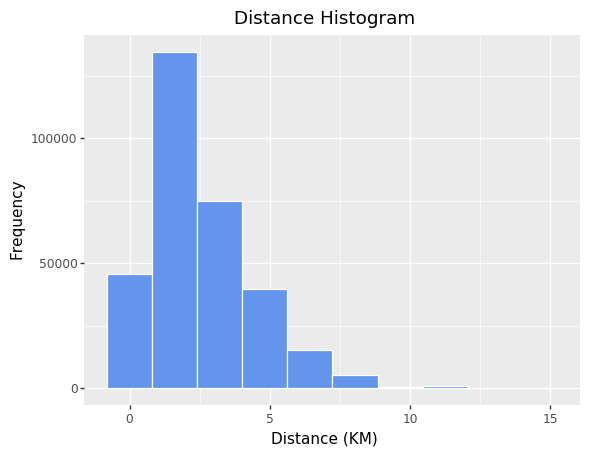

<ggplot: (-9223372036562192871)>

In [92]:
plot = (ggplot(df_trips_distance_kph) +
            geom_histogram(aes(x = 'DistanceKM'),
                          color = 'white',
                          fill = 'cornflowerblue',
                          bins = 10) +
        ggtitle('Distance Histogram') +
        xlab('Distance (KM)') +
        ylab('Frequency')
       )
plot

So we have a skewed distribution around 1 kilometers, but some higher. Next let's look at KPH.

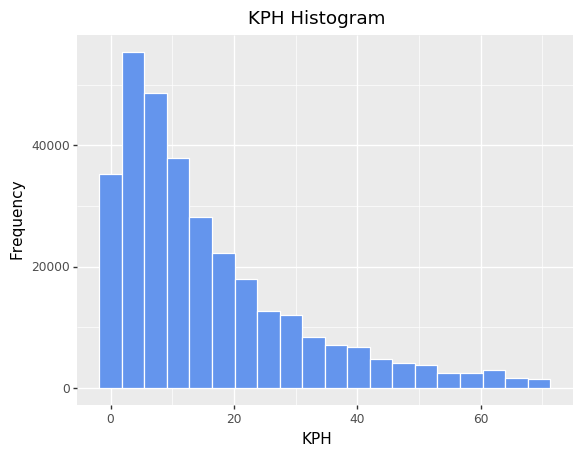

<ggplot: (-9223372036537939775)>

In [93]:
plot = (ggplot(df_trips_distance_kph) +
            geom_histogram(aes(x = 'KPH'),
                          color = 'white',
                          fill = 'cornflowerblue',
                          bins = 20) +
        ggtitle('KPH Histogram') +
        xlab('KPH') +
        ylab('Frequency')
       )
plot

Some of these are some very fast bikers! Let's take a look at the top trip from this selection to see where to see what kind of trip this is.

In [94]:
df_top_speed = df_trips_distance_kph.sort_values(by = ['KPH']).tail(1)
df_top_speed

,StartStation,EndStation,Duration,StartLat,StartLon,EndLat,EndLon,DistanceKM,KPH
94724,30010,30004,2,44.987996,-93.279854,44.97654,-93.25535,2.314305,69.429154


In [95]:
start_row = [df_top_speed['StartLat'].iloc[0], df_top_speed['StartLon'].iloc[0]]
end_row = [df_top_speed['EndLat'].iloc[0], df_top_speed['EndLon'].iloc[0]]
start_end = [start_row, end_row]

df_top_speed_map = pd.DataFrame(start_end)
df_top_speed_map.columns = ['Latitude', 'Longitude']
build_map(df_top_speed_map, is_simple = True)

Somehow I find it hard to believe that someone could really bike 70 kilometers per hour between these two stops. Perhaps someone loaded the bike onto a vehicle? It's hard to say. Perhaps I calculated duration and distance incorrectly, or the data isn't 100% accurate.

## Conclusion

There weren't many features in this dataset, and yet, some interesting questions can be asked and results found. I asked three questions of this dataset, let's summarize the results:

* Do station locations map to established neighborhoods?

Yes! At least at a first glance, some clustering algorithms come up with clusters that align very closely with actual neighboorhoods. This could be because stations and neighborhoods are based on geographic boundaries. It could also be that neighboorhoods and stations follow patterns of density. Results here could be improved if hard boundaries, like a river, could be fed into the clustering algorithm. This would prevent the few stations that were incorrectly clustered.

* Can the total number of trips be predicted based on weather data to 80% accuracy?

No! At least not with the data provided. The regression I used in addition to several engineered features could only get to about 60% accuracy. Perhaps more data is required.

* Can the speed of a trip be calculated?

Yes! Well, sort of! Without knowing the actual route someone took, my 'best guess' is to calculate the distance between two stations as a straight line. While not completely accurate, it does provide a decent estimation and should be internally consistent enough for start-end station pairs. 